# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [2]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [5]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms1 = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [6]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [7]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [8]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 15
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [9]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['-', '-', '-', '-', 'q', '-', '-', '-']
['-', 'K', 'P', '-', '-', '-', '-', '-']
['-', 'P', '-', 'Q', '-', '-', '-', '-']
['P', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'p', '-', 'k', '-']
['-', 'p', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']


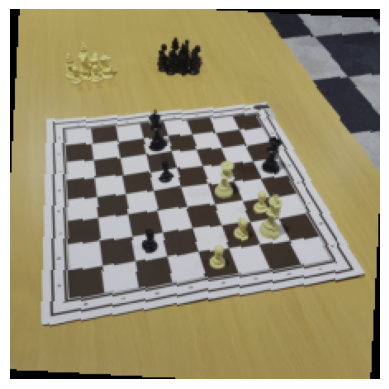

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


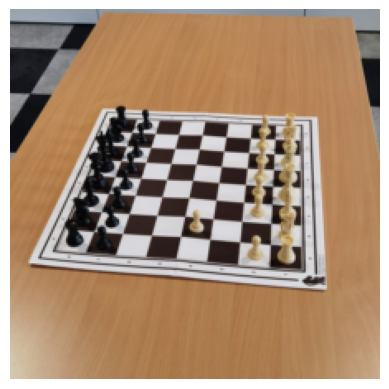

In [10]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 64),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()).round().astype(int)
    all_labels = all_labels.detach().numpy().astype(int)
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    #print("Test1 :",all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    return accuracy, recall, precision, f1
def claculateMissMatchs(all_preds, all_labels):
    accuracyList = np.zeros(64, dtype=int)
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      missmatched =total- correct
      accuracyList[missmatched] += 1
    return accuracyList

## Train the model

Define function to perform one iteration

In [13]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32]
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.append(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [14]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [15]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 431/431 [01:27<00:00,  4.92it/s]


Train loss: 12.24469 	 Train acc: 0.00000 	 Train recall: 0.14725 	 Train precision: 0.18998 	 Train f1: 0.07402


100%|██████████| 147/147 [00:09<00:00, 15.36it/s]


Val loss: 11.70263 	 Val acc: 0.00000 	 Val recall: 0.17376 	 Val precision: 0.18458 	 Val f1: 0.11290

Epoch 2


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 9.18656 	 Train acc: 0.00000 	 Train recall: 0.18427 	 Train precision: 0.20533 	 Train f1: 0.12098


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 9.08443 	 Val acc: 0.00000 	 Val recall: 0.19662 	 Val precision: 0.20816 	 Val f1: 0.14539

Epoch 3


100%|██████████| 431/431 [01:27<00:00,  4.95it/s]


Train loss: 6.00683 	 Train acc: 0.00000 	 Train recall: 0.21874 	 Train precision: 0.22951 	 Train f1: 0.17118


100%|██████████| 147/147 [00:09<00:00, 15.42it/s]


Val loss: 7.40292 	 Val acc: 0.00000 	 Val recall: 0.20086 	 Val precision: 0.21939 	 Val f1: 0.17482

Epoch 4


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 3.31614 	 Train acc: 0.00000 	 Train recall: 0.26670 	 Train precision: 0.26066 	 Train f1: 0.22132


100%|██████████| 147/147 [00:09<00:00, 15.26it/s]


Val loss: 4.14102 	 Val acc: 0.00000 	 Val recall: 0.25711 	 Val precision: 0.25180 	 Val f1: 0.21532

Epoch 5


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 1.66710 	 Train acc: 0.00000 	 Train recall: 0.31377 	 Train precision: 0.29416 	 Train f1: 0.26864


100%|██████████| 147/147 [00:09<00:00, 15.42it/s]


Val loss: 2.29955 	 Val acc: 0.00000 	 Val recall: 0.30699 	 Val precision: 0.28664 	 Val f1: 0.25953

Epoch 6


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.92910 	 Train acc: 0.00000 	 Train recall: 0.37195 	 Train precision: 0.33438 	 Train f1: 0.32097


100%|██████████| 147/147 [00:09<00:00, 15.31it/s]


Val loss: 2.23612 	 Val acc: 0.00000 	 Val recall: 0.32677 	 Val precision: 0.29781 	 Val f1: 0.27147

Epoch 7


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.74527 	 Train acc: 0.00000 	 Train recall: 0.40882 	 Train precision: 0.36030 	 Train f1: 0.35339


100%|██████████| 147/147 [00:09<00:00, 15.42it/s]


Val loss: 2.01408 	 Val acc: 0.00000 	 Val recall: 0.33010 	 Val precision: 0.29620 	 Val f1: 0.27448

Epoch 8


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.56962 	 Train acc: 0.00000 	 Train recall: 0.45029 	 Train precision: 0.39253 	 Train f1: 0.39169


100%|██████████| 147/147 [00:09<00:00, 15.45it/s]


Val loss: 1.23132 	 Val acc: 0.00000 	 Val recall: 0.40147 	 Val precision: 0.34274 	 Val f1: 0.33282

Epoch 9


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.40935 	 Train acc: 0.00000 	 Train recall: 0.49898 	 Train precision: 0.43498 	 Train f1: 0.44008


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 1.04250 	 Val acc: 0.00000 	 Val recall: 0.41245 	 Val precision: 0.35031 	 Val f1: 0.34502

Epoch 10


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.33811 	 Train acc: 0.00000 	 Train recall: 0.53913 	 Train precision: 0.47089 	 Train f1: 0.47999


100%|██████████| 147/147 [00:09<00:00, 15.39it/s]


Val loss: 1.04912 	 Val acc: 0.00000 	 Val recall: 0.42657 	 Val precision: 0.36122 	 Val f1: 0.35577

Epoch 11


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.33078 	 Train acc: 0.00015 	 Train recall: 0.54729 	 Train precision: 0.47755 	 Train f1: 0.48855


100%|██████████| 147/147 [00:09<00:00, 15.45it/s]


Val loss: 0.94942 	 Val acc: 0.00000 	 Val recall: 0.44663 	 Val precision: 0.37491 	 Val f1: 0.37418

Epoch 12


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.48601 	 Train acc: 0.00000 	 Train recall: 0.50009 	 Train precision: 0.43133 	 Train f1: 0.43922


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 1.00093 	 Val acc: 0.00000 	 Val recall: 0.41312 	 Val precision: 0.35420 	 Val f1: 0.34817

Epoch 13


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.33100 	 Train acc: 0.00015 	 Train recall: 0.55055 	 Train precision: 0.48225 	 Train f1: 0.49509


100%|██████████| 147/147 [00:09<00:00, 15.26it/s]


Val loss: 0.88593 	 Val acc: 0.00046 	 Val recall: 0.46595 	 Val precision: 0.39212 	 Val f1: 0.39520

Epoch 14


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.26189 	 Train acc: 0.00062 	 Train recall: 0.59079 	 Train precision: 0.52436 	 Train f1: 0.53961


100%|██████████| 147/147 [00:09<00:00, 15.40it/s]


Val loss: 0.84004 	 Val acc: 0.00228 	 Val recall: 0.47732 	 Val precision: 0.40398 	 Val f1: 0.40828

Epoch 15


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.35137 	 Train acc: 0.00077 	 Train recall: 0.55978 	 Train precision: 0.48718 	 Train f1: 0.50176


100%|██████████| 147/147 [00:09<00:00, 15.30it/s]


Val loss: 0.79306 	 Val acc: 0.00091 	 Val recall: 0.48821 	 Val precision: 0.40850 	 Val f1: 0.41689

Epoch 16


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.20313 	 Train acc: 0.00155 	 Train recall: 0.63024 	 Train precision: 0.56777 	 Train f1: 0.58563


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.69072 	 Val acc: 0.00046 	 Val recall: 0.49652 	 Val precision: 0.42544 	 Val f1: 0.43277

Epoch 17


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.18202 	 Train acc: 0.00371 	 Train recall: 0.65548 	 Train precision: 0.59460 	 Train f1: 0.61327


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 0.64839 	 Val acc: 0.00274 	 Val recall: 0.51337 	 Val precision: 0.43480 	 Val f1: 0.44633

Epoch 18


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.18383 	 Train acc: 0.00309 	 Train recall: 0.66259 	 Train precision: 0.60007 	 Train f1: 0.61961


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 0.89121 	 Val acc: 0.00000 	 Val recall: 0.47224 	 Val precision: 0.39854 	 Val f1: 0.40113

Epoch 19


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.40571 	 Train acc: 0.00015 	 Train recall: 0.54714 	 Train precision: 0.47446 	 Train f1: 0.48947


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 0.86350 	 Val acc: 0.00000 	 Val recall: 0.44219 	 Val precision: 0.38052 	 Val f1: 0.38258

Epoch 20


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.17334 	 Train acc: 0.00433 	 Train recall: 0.65970 	 Train precision: 0.60218 	 Train f1: 0.62045


100%|██████████| 147/147 [00:09<00:00, 15.45it/s]


Val loss: 0.55760 	 Val acc: 0.00912 	 Val recall: 0.52070 	 Val precision: 0.44536 	 Val f1: 0.45782

Epoch 21


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.18118 	 Train acc: 0.00944 	 Train recall: 0.67414 	 Train precision: 0.61074 	 Train f1: 0.63167


100%|██████████| 147/147 [00:09<00:00, 15.40it/s]


Val loss: 0.71480 	 Val acc: 0.00000 	 Val recall: 0.50123 	 Val precision: 0.42577 	 Val f1: 0.43470

Epoch 22


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.16628 	 Train acc: 0.00603 	 Train recall: 0.67271 	 Train precision: 0.61538 	 Train f1: 0.63463


100%|██████████| 147/147 [00:09<00:00, 15.34it/s]


Val loss: 0.60779 	 Val acc: 0.00182 	 Val recall: 0.51752 	 Val precision: 0.44802 	 Val f1: 0.45739

Epoch 23


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.13565 	 Train acc: 0.00696 	 Train recall: 0.71080 	 Train precision: 0.66142 	 Train f1: 0.67921


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.61674 	 Val acc: 0.01551 	 Val recall: 0.53085 	 Val precision: 0.45888 	 Val f1: 0.47248

Epoch 24


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.11328 	 Train acc: 0.01253 	 Train recall: 0.73430 	 Train precision: 0.69110 	 Train f1: 0.70738


100%|██████████| 147/147 [00:09<00:00, 15.25it/s]


Val loss: 0.58148 	 Val acc: 0.00867 	 Val recall: 0.54031 	 Val precision: 0.47084 	 Val f1: 0.48383

Epoch 25


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.09592 	 Train acc: 0.02243 	 Train recall: 0.76041 	 Train precision: 0.72199 	 Train f1: 0.73712


100%|██████████| 147/147 [00:09<00:00, 15.40it/s]


Val loss: 0.54576 	 Val acc: 0.00912 	 Val recall: 0.53099 	 Val precision: 0.46108 	 Val f1: 0.47450

Epoch 26


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.26440 	 Train acc: 0.00356 	 Train recall: 0.62681 	 Train precision: 0.55628 	 Train f1: 0.57755


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.68093 	 Val acc: 0.00000 	 Val recall: 0.50426 	 Val precision: 0.43407 	 Val f1: 0.44715

Epoch 27


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.13659 	 Train acc: 0.01176 	 Train recall: 0.70623 	 Train precision: 0.65809 	 Train f1: 0.67547


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.59824 	 Val acc: 0.01277 	 Val recall: 0.54013 	 Val precision: 0.46743 	 Val f1: 0.48251

Epoch 28


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.10303 	 Train acc: 0.01887 	 Train recall: 0.74931 	 Train precision: 0.71024 	 Train f1: 0.72534


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.55939 	 Val acc: 0.00912 	 Val recall: 0.54385 	 Val precision: 0.47203 	 Val f1: 0.48467

Epoch 29


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.08710 	 Train acc: 0.03047 	 Train recall: 0.76968 	 Train precision: 0.73346 	 Train f1: 0.74807


100%|██████████| 147/147 [00:09<00:00, 15.43it/s]


Val loss: 0.56691 	 Val acc: 0.01460 	 Val recall: 0.54730 	 Val precision: 0.47732 	 Val f1: 0.49169

Epoch 30


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.06900 	 Train acc: 0.05800 	 Train recall: 0.80460 	 Train precision: 0.77749 	 Train f1: 0.78858


100%|██████████| 147/147 [00:09<00:00, 15.44it/s]


Val loss: 0.49484 	 Val acc: 0.02372 	 Val recall: 0.55781 	 Val precision: 0.49586 	 Val f1: 0.50888

Epoch 31


100%|██████████| 431/431 [01:26<00:00,  4.97it/s]


Train loss: 0.08420 	 Train acc: 0.03604 	 Train recall: 0.78174 	 Train precision: 0.74700 	 Train f1: 0.76152


100%|██████████| 147/147 [00:09<00:00, 15.42it/s]


Val loss: 0.62932 	 Val acc: 0.00000 	 Val recall: 0.52769 	 Val precision: 0.46508 	 Val f1: 0.47515

Epoch 32


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.08805 	 Train acc: 0.02784 	 Train recall: 0.76706 	 Train precision: 0.73256 	 Train f1: 0.74660


100%|██████████| 147/147 [00:09<00:00, 15.41it/s]


Val loss: 0.51072 	 Val acc: 0.00091 	 Val recall: 0.54408 	 Val precision: 0.47716 	 Val f1: 0.48937

Epoch 33


100%|██████████| 431/431 [01:26<00:00,  4.96it/s]


Train loss: 0.14051 	 Train acc: 0.01253 	 Train recall: 0.72390 	 Train precision: 0.67372 	 Train f1: 0.69276


100%|██████████| 147/147 [00:09<00:00, 15.26it/s]


Val loss: 0.78729 	 Val acc: 0.00182 	 Val recall: 0.49575 	 Val precision: 0.43316 	 Val f1: 0.44605

Epoch 34


100%|██████████| 431/431 [01:28<00:00,  4.87it/s]


Train loss: 0.17005 	 Train acc: 0.00882 	 Train recall: 0.68576 	 Train precision: 0.63134 	 Train f1: 0.65115


100%|██████████| 147/147 [00:09<00:00, 14.82it/s]


Val loss: 0.62668 	 Val acc: 0.01232 	 Val recall: 0.53990 	 Val precision: 0.46560 	 Val f1: 0.48216

Epoch 35


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.07305 	 Train acc: 0.04826 	 Train recall: 0.79394 	 Train precision: 0.76641 	 Train f1: 0.77774


100%|██████████| 147/147 [00:09<00:00, 14.83it/s]


Val loss: 0.52521 	 Val acc: 0.02783 	 Val recall: 0.56390 	 Val precision: 0.50667 	 Val f1: 0.51703

Epoch 36


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.05350 	 Train acc: 0.08817 	 Train recall: 0.83780 	 Train precision: 0.81799 	 Train f1: 0.82659


100%|██████████| 147/147 [00:09<00:00, 14.83it/s]


Val loss: 0.46711 	 Val acc: 0.02372 	 Val recall: 0.56251 	 Val precision: 0.50155 	 Val f1: 0.51547

Epoch 37


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 0.04502 	 Train acc: 0.11214 	 Train recall: 0.85562 	 Train precision: 0.83989 	 Train f1: 0.84675


100%|██████████| 147/147 [00:09<00:00, 14.70it/s]


Val loss: 0.43711 	 Val acc: 0.02099 	 Val recall: 0.57735 	 Val precision: 0.52263 	 Val f1: 0.53551

Epoch 38


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.04804 	 Train acc: 0.11168 	 Train recall: 0.85303 	 Train precision: 0.83576 	 Train f1: 0.84346


100%|██████████| 147/147 [00:09<00:00, 14.91it/s]


Val loss: 0.59957 	 Val acc: 0.00639 	 Val recall: 0.54687 	 Val precision: 0.48109 	 Val f1: 0.49666

Epoch 39


100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


Train loss: 0.25255 	 Train acc: 0.01067 	 Train recall: 0.66337 	 Train precision: 0.59340 	 Train f1: 0.61770


100%|██████████| 147/147 [00:09<00:00, 14.83it/s]


Val loss: 0.66334 	 Val acc: 0.00274 	 Val recall: 0.51414 	 Val precision: 0.45437 	 Val f1: 0.46537

Epoch 40


100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


Train loss: 0.08007 	 Train acc: 0.04594 	 Train recall: 0.78322 	 Train precision: 0.75102 	 Train f1: 0.76449


100%|██████████| 147/147 [00:09<00:00, 14.91it/s]


Val loss: 0.49925 	 Val acc: 0.03057 	 Val recall: 0.56964 	 Val precision: 0.50989 	 Val f1: 0.52322

Epoch 41


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 0.04989 	 Train acc: 0.10240 	 Train recall: 0.84841 	 Train precision: 0.83123 	 Train f1: 0.83884


100%|██████████| 147/147 [00:09<00:00, 14.91it/s]


Val loss: 0.50235 	 Val acc: 0.03057 	 Val recall: 0.56849 	 Val precision: 0.51078 	 Val f1: 0.52342

Epoch 42


100%|██████████| 431/431 [01:29<00:00,  4.79it/s]


Train loss: 0.04098 	 Train acc: 0.13643 	 Train recall: 0.86826 	 Train precision: 0.85428 	 Train f1: 0.86053


100%|██████████| 147/147 [00:09<00:00, 14.91it/s]


Val loss: 0.44572 	 Val acc: 0.03239 	 Val recall: 0.57556 	 Val precision: 0.52617 	 Val f1: 0.53722

Epoch 43


100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


Train loss: 0.03258 	 Train acc: 0.20232 	 Train recall: 0.89114 	 Train precision: 0.88348 	 Train f1: 0.88692


100%|██████████| 147/147 [00:09<00:00, 14.88it/s]


Val loss: 0.43042 	 Val acc: 0.03832 	 Val recall: 0.57908 	 Val precision: 0.53072 	 Val f1: 0.54158

Epoch 44


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.03222 	 Train acc: 0.19938 	 Train recall: 0.89193 	 Train precision: 0.88398 	 Train f1: 0.88754


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.42545 	 Val acc: 0.03650 	 Val recall: 0.58394 	 Val precision: 0.53008 	 Val f1: 0.54388

Epoch 45


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.03485 	 Train acc: 0.17649 	 Train recall: 0.88394 	 Train precision: 0.87496 	 Train f1: 0.87894


100%|██████████| 147/147 [00:09<00:00, 14.92it/s]


Val loss: 0.42020 	 Val acc: 0.00776 	 Val recall: 0.56327 	 Val precision: 0.52045 	 Val f1: 0.52997

Epoch 46


100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


Train loss: 0.03590 	 Train acc: 0.17680 	 Train recall: 0.87938 	 Train precision: 0.87132 	 Train f1: 0.87484


100%|██████████| 147/147 [00:09<00:00, 14.90it/s]


Val loss: 0.41113 	 Val acc: 0.03376 	 Val recall: 0.58565 	 Val precision: 0.53491 	 Val f1: 0.54832

Epoch 47


100%|██████████| 431/431 [01:29<00:00,  4.79it/s]


Train loss: 0.03768 	 Train acc: 0.15174 	 Train recall: 0.87346 	 Train precision: 0.86398 	 Train f1: 0.86811


100%|██████████| 147/147 [00:09<00:00, 14.90it/s]


Val loss: 0.43703 	 Val acc: 0.03558 	 Val recall: 0.58302 	 Val precision: 0.53203 	 Val f1: 0.54466

Epoch 48


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 0.19193 	 Train acc: 0.04578 	 Train recall: 0.73305 	 Train precision: 0.67316 	 Train f1: 0.69673


100%|██████████| 147/147 [00:09<00:00, 14.79it/s]


Val loss: 1.11640 	 Val acc: 0.00046 	 Val recall: 0.43922 	 Val precision: 0.38738 	 Val f1: 0.38840

Epoch 49


100%|██████████| 431/431 [01:30<00:00,  4.79it/s]


Train loss: 0.11241 	 Train acc: 0.03248 	 Train recall: 0.75370 	 Train precision: 0.70913 	 Train f1: 0.72749


100%|██████████| 147/147 [00:09<00:00, 14.91it/s]


Val loss: 0.48481 	 Val acc: 0.02874 	 Val recall: 0.57425 	 Val precision: 0.51572 	 Val f1: 0.52963

Epoch 50


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.04775 	 Train acc: 0.11168 	 Train recall: 0.85450 	 Train precision: 0.83942 	 Train f1: 0.84627


100%|██████████| 147/147 [00:09<00:00, 14.88it/s]


Val loss: 0.50983 	 Val acc: 0.02783 	 Val recall: 0.56180 	 Val precision: 0.51099 	 Val f1: 0.52162

Epoch 51


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 0.03502 	 Train acc: 0.17834 	 Train recall: 0.88590 	 Train precision: 0.87523 	 Train f1: 0.88011


100%|██████████| 147/147 [00:10<00:00, 14.06it/s]


Val loss: 0.45820 	 Val acc: 0.03558 	 Val recall: 0.58222 	 Val precision: 0.53152 	 Val f1: 0.54424

Epoch 52


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.02837 	 Train acc: 0.26156 	 Train recall: 0.90626 	 Train precision: 0.90132 	 Train f1: 0.90352


100%|██████████| 147/147 [00:09<00:00, 14.77it/s]


Val loss: 0.45393 	 Val acc: 0.03832 	 Val recall: 0.58228 	 Val precision: 0.53723 	 Val f1: 0.54766

Epoch 53


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 0.02724 	 Train acc: 0.29451 	 Train recall: 0.91446 	 Train precision: 0.91038 	 Train f1: 0.91226


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 0.52954 	 Val acc: 0.02874 	 Val recall: 0.56591 	 Val precision: 0.51483 	 Val f1: 0.52699

Epoch 54


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.07590 	 Train acc: 0.05847 	 Train recall: 0.82172 	 Train precision: 0.79167 	 Train f1: 0.80491


100%|██████████| 147/147 [00:10<00:00, 14.06it/s]


Val loss: 0.51018 	 Val acc: 0.03741 	 Val recall: 0.56773 	 Val precision: 0.51539 	 Val f1: 0.52906

Epoch 55


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.05389 	 Train acc: 0.11972 	 Train recall: 0.84929 	 Train precision: 0.83013 	 Train f1: 0.83882


100%|██████████| 147/147 [00:09<00:00, 14.83it/s]


Val loss: 0.66249 	 Val acc: 0.00411 	 Val recall: 0.55631 	 Val precision: 0.48832 	 Val f1: 0.50653

Epoch 56


100%|██████████| 431/431 [01:29<00:00,  4.82it/s]


Train loss: 0.08511 	 Train acc: 0.04965 	 Train recall: 0.80049 	 Train precision: 0.76654 	 Train f1: 0.78170


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 0.52897 	 Val acc: 0.03102 	 Val recall: 0.56510 	 Val precision: 0.50740 	 Val f1: 0.52128

Epoch 57


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.05923 	 Train acc: 0.09776 	 Train recall: 0.84133 	 Train precision: 0.81754 	 Train f1: 0.82837


100%|██████████| 147/147 [00:09<00:00, 15.20it/s]


Val loss: 0.47058 	 Val acc: 0.03148 	 Val recall: 0.56800 	 Val precision: 0.52417 	 Val f1: 0.53377

Epoch 58


100%|██████████| 431/431 [01:27<00:00,  4.92it/s]


Train loss: 0.04280 	 Train acc: 0.14617 	 Train recall: 0.87042 	 Train precision: 0.85648 	 Train f1: 0.86300


100%|██████████| 147/147 [00:09<00:00, 15.22it/s]


Val loss: 0.49423 	 Val acc: 0.03467 	 Val recall: 0.57013 	 Val precision: 0.52037 	 Val f1: 0.53103

Epoch 59


100%|██████████| 431/431 [01:27<00:00,  4.90it/s]


Train loss: 0.03088 	 Train acc: 0.23186 	 Train recall: 0.89658 	 Train precision: 0.88949 	 Train f1: 0.89281


100%|██████████| 147/147 [00:10<00:00, 14.06it/s]


Val loss: 0.46580 	 Val acc: 0.04197 	 Val recall: 0.58712 	 Val precision: 0.54692 	 Val f1: 0.55496

Epoch 60


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.02978 	 Train acc: 0.27332 	 Train recall: 0.90779 	 Train precision: 0.90141 	 Train f1: 0.90440


100%|██████████| 147/147 [00:10<00:00, 14.69it/s]


Val loss: 0.52389 	 Val acc: 0.01186 	 Val recall: 0.56067 	 Val precision: 0.51426 	 Val f1: 0.52580

Epoch 61


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.11473 	 Train acc: 0.04795 	 Train recall: 0.79206 	 Train precision: 0.74784 	 Train f1: 0.76710


100%|██████████| 147/147 [00:09<00:00, 14.87it/s]


Val loss: 0.69079 	 Val acc: 0.01825 	 Val recall: 0.54005 	 Val precision: 0.47502 	 Val f1: 0.49119

Epoch 62


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.05509 	 Train acc: 0.10317 	 Train recall: 0.84284 	 Train precision: 0.82163 	 Train f1: 0.83124


100%|██████████| 147/147 [00:10<00:00, 14.61it/s]


Val loss: 0.53509 	 Val acc: 0.02327 	 Val recall: 0.56086 	 Val precision: 0.50419 	 Val f1: 0.51926

Epoch 63


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.03202 	 Train acc: 0.23434 	 Train recall: 0.90160 	 Train precision: 0.89489 	 Train f1: 0.89800


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.50246 	 Val acc: 0.03923 	 Val recall: 0.57380 	 Val precision: 0.52371 	 Val f1: 0.53589

Epoch 64


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.02537 	 Train acc: 0.31199 	 Train recall: 0.91948 	 Train precision: 0.91516 	 Train f1: 0.91715


100%|██████████| 147/147 [00:09<00:00, 14.79it/s]


Val loss: 0.46855 	 Val acc: 0.03193 	 Val recall: 0.58011 	 Val precision: 0.53943 	 Val f1: 0.54651

Epoch 65


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.01913 	 Train acc: 0.40356 	 Train recall: 0.93702 	 Train precision: 0.93654 	 Train f1: 0.93670


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.45435 	 Val acc: 0.04243 	 Val recall: 0.58334 	 Val precision: 0.54302 	 Val f1: 0.55139

Epoch 66


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.02268 	 Train acc: 0.38221 	 Train recall: 0.93280 	 Train precision: 0.93069 	 Train f1: 0.93161


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.48393 	 Val acc: 0.04197 	 Val recall: 0.57624 	 Val precision: 0.53206 	 Val f1: 0.54180

Epoch 67


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.02573 	 Train acc: 0.29946 	 Train recall: 0.91737 	 Train precision: 0.91229 	 Train f1: 0.91469


100%|██████████| 147/147 [00:09<00:00, 14.86it/s]


Val loss: 0.48488 	 Val acc: 0.04151 	 Val recall: 0.58409 	 Val precision: 0.54270 	 Val f1: 0.55168

Epoch 68


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.02790 	 Train acc: 0.26032 	 Train recall: 0.90804 	 Train precision: 0.90170 	 Train f1: 0.90460


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.45563 	 Val acc: 0.03786 	 Val recall: 0.58137 	 Val precision: 0.53889 	 Val f1: 0.54769

Epoch 69


100%|██████████| 431/431 [01:31<00:00,  4.74it/s]


Train loss: 0.02335 	 Train acc: 0.31508 	 Train recall: 0.91782 	 Train precision: 0.91657 	 Train f1: 0.91706


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.45730 	 Val acc: 0.03969 	 Val recall: 0.58671 	 Val precision: 0.53764 	 Val f1: 0.54996

Epoch 70


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.07546 	 Train acc: 0.07904 	 Train recall: 0.82697 	 Train precision: 0.79711 	 Train f1: 0.81061


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.62345 	 Val acc: 0.00684 	 Val recall: 0.55532 	 Val precision: 0.50434 	 Val f1: 0.51650

Epoch 71


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.12824 	 Train acc: 0.03650 	 Train recall: 0.76941 	 Train precision: 0.71884 	 Train f1: 0.74027


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.56842 	 Val acc: 0.03193 	 Val recall: 0.55347 	 Val precision: 0.49806 	 Val f1: 0.51225

Epoch 72


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.04046 	 Train acc: 0.15855 	 Train recall: 0.87248 	 Train precision: 0.86093 	 Train f1: 0.86627


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.50886 	 Val acc: 0.03467 	 Val recall: 0.57593 	 Val precision: 0.53008 	 Val f1: 0.54043

Epoch 73


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01996 	 Train acc: 0.38824 	 Train recall: 0.93343 	 Train precision: 0.93211 	 Train f1: 0.93268


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.48156 	 Val acc: 0.04288 	 Val recall: 0.58523 	 Val precision: 0.54173 	 Val f1: 0.55232

Epoch 74


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.01318 	 Train acc: 0.57247 	 Train recall: 0.95992 	 Train precision: 0.96115 	 Train f1: 0.96049


100%|██████████| 147/147 [00:09<00:00, 14.77it/s]


Val loss: 0.48038 	 Val acc: 0.04425 	 Val recall: 0.58582 	 Val precision: 0.54641 	 Val f1: 0.55436

Epoch 75


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01178 	 Train acc: 0.62289 	 Train recall: 0.96558 	 Train precision: 0.96734 	 Train f1: 0.96642


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.47026 	 Val acc: 0.04516 	 Val recall: 0.58450 	 Val precision: 0.54826 	 Val f1: 0.55506

Epoch 76


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 0.01256 	 Train acc: 0.59536 	 Train recall: 0.96239 	 Train precision: 0.96358 	 Train f1: 0.96296


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.46234 	 Val acc: 0.04471 	 Val recall: 0.58401 	 Val precision: 0.54752 	 Val f1: 0.55525

Epoch 77


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.01425 	 Train acc: 0.52529 	 Train recall: 0.95318 	 Train precision: 0.95359 	 Train f1: 0.95333


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.46154 	 Val acc: 0.04562 	 Val recall: 0.58437 	 Val precision: 0.54703 	 Val f1: 0.55432

Epoch 78


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01676 	 Train acc: 0.45955 	 Train recall: 0.94293 	 Train precision: 0.94314 	 Train f1: 0.94297


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.45314 	 Val acc: 0.04425 	 Val recall: 0.59136 	 Val precision: 0.55164 	 Val f1: 0.56107

Epoch 79


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.07220 	 Train acc: 0.21655 	 Train recall: 0.86077 	 Train precision: 0.83393 	 Train f1: 0.84637


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.89893 	 Val acc: 0.00000 	 Val recall: 0.51839 	 Val precision: 0.44690 	 Val f1: 0.46132

Epoch 80


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.09538 	 Train acc: 0.05244 	 Train recall: 0.79817 	 Train precision: 0.76222 	 Train f1: 0.77794


100%|██████████| 147/147 [00:10<00:00, 14.67it/s]


Val loss: 0.53038 	 Val acc: 0.03923 	 Val recall: 0.56885 	 Val precision: 0.52258 	 Val f1: 0.53417

Epoch 81


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.02852 	 Train acc: 0.25429 	 Train recall: 0.90444 	 Train precision: 0.89791 	 Train f1: 0.90096


100%|██████████| 147/147 [00:09<00:00, 14.70it/s]


Val loss: 0.45515 	 Val acc: 0.04288 	 Val recall: 0.58378 	 Val precision: 0.54373 	 Val f1: 0.55241

Epoch 82


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01421 	 Train acc: 0.53813 	 Train recall: 0.95483 	 Train precision: 0.95652 	 Train f1: 0.95563


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.43596 	 Val acc: 0.04380 	 Val recall: 0.58104 	 Val precision: 0.54775 	 Val f1: 0.55290

Epoch 83


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.01088 	 Train acc: 0.66249 	 Train recall: 0.96982 	 Train precision: 0.97167 	 Train f1: 0.97071


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.43939 	 Val acc: 0.04516 	 Val recall: 0.58534 	 Val precision: 0.55027 	 Val f1: 0.55715

Epoch 84


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01055 	 Train acc: 0.66636 	 Train recall: 0.97000 	 Train precision: 0.97171 	 Train f1: 0.97084


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 0.42587 	 Val acc: 0.04516 	 Val recall: 0.59032 	 Val precision: 0.55773 	 Val f1: 0.56206

Epoch 85


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.01199 	 Train acc: 0.61454 	 Train recall: 0.96326 	 Train precision: 0.96508 	 Train f1: 0.96414


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.42333 	 Val acc: 0.04653 	 Val recall: 0.58914 	 Val precision: 0.55692 	 Val f1: 0.56231

Epoch 86


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01345 	 Train acc: 0.55932 	 Train recall: 0.95690 	 Train precision: 0.95869 	 Train f1: 0.95774


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.42054 	 Val acc: 0.04562 	 Val recall: 0.58816 	 Val precision: 0.55522 	 Val f1: 0.56086

Epoch 87


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.01525 	 Train acc: 0.50441 	 Train recall: 0.94857 	 Train precision: 0.94977 	 Train f1: 0.94912


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.40845 	 Val acc: 0.04790 	 Val recall: 0.58794 	 Val precision: 0.55573 	 Val f1: 0.56208

Epoch 88


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.05988 	 Train acc: 0.27765 	 Train recall: 0.88156 	 Train precision: 0.85729 	 Train f1: 0.86858


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.83771 	 Val acc: 0.00365 	 Val recall: 0.53472 	 Val precision: 0.46516 	 Val f1: 0.48432

Epoch 89


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.09840 	 Train acc: 0.05708 	 Train recall: 0.80398 	 Train precision: 0.76603 	 Train f1: 0.78287


100%|██████████| 147/147 [00:09<00:00, 14.82it/s]


Val loss: 0.51557 	 Val acc: 0.03422 	 Val recall: 0.56885 	 Val precision: 0.52041 	 Val f1: 0.53271

Epoch 90


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.02862 	 Train acc: 0.26961 	 Train recall: 0.90911 	 Train precision: 0.90231 	 Train f1: 0.90554


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.48242 	 Val acc: 0.04608 	 Val recall: 0.58342 	 Val precision: 0.54165 	 Val f1: 0.55061

Epoch 91


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 0.01859 	 Train acc: 0.44548 	 Train recall: 0.94479 	 Train precision: 0.94321 	 Train f1: 0.94395


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 0.50023 	 Val acc: 0.03969 	 Val recall: 0.57391 	 Val precision: 0.53765 	 Val f1: 0.54471

Epoch 92


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.01852 	 Train acc: 0.48677 	 Train recall: 0.94995 	 Train precision: 0.94840 	 Train f1: 0.94914


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.51427 	 Val acc: 0.04243 	 Val recall: 0.58579 	 Val precision: 0.54182 	 Val f1: 0.55297

Epoch 93


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01275 	 Train acc: 0.59675 	 Train recall: 0.96272 	 Train precision: 0.96319 	 Train f1: 0.96293


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.44829 	 Val acc: 0.04653 	 Val recall: 0.58591 	 Val precision: 0.55122 	 Val f1: 0.55790

Epoch 94


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01255 	 Train acc: 0.61206 	 Train recall: 0.96429 	 Train precision: 0.96481 	 Train f1: 0.96453


100%|██████████| 147/147 [00:10<00:00, 14.67it/s]


Val loss: 0.46537 	 Val acc: 0.04836 	 Val recall: 0.58704 	 Val precision: 0.55236 	 Val f1: 0.55882

Epoch 95


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 0.01148 	 Train acc: 0.61903 	 Train recall: 0.96455 	 Train precision: 0.96626 	 Train f1: 0.96538


100%|██████████| 147/147 [00:09<00:00, 14.76it/s]


Val loss: 0.44807 	 Val acc: 0.04836 	 Val recall: 0.58908 	 Val precision: 0.55505 	 Val f1: 0.56184

Epoch 96


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.01150 	 Train acc: 0.62753 	 Train recall: 0.96491 	 Train precision: 0.96652 	 Train f1: 0.96568


100%|██████████| 147/147 [00:10<00:00, 14.66it/s]


Val loss: 0.45128 	 Val acc: 0.04745 	 Val recall: 0.59186 	 Val precision: 0.55493 	 Val f1: 0.56306

Epoch 97


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 0.01279 	 Train acc: 0.57185 	 Train recall: 0.95799 	 Train precision: 0.95960 	 Train f1: 0.95876


100%|██████████| 147/147 [00:09<00:00, 15.03it/s]


Val loss: 0.44154 	 Val acc: 0.04653 	 Val recall: 0.59121 	 Val precision: 0.55659 	 Val f1: 0.56209

Epoch 98


100%|██████████| 431/431 [01:29<00:00,  4.84it/s]


Train loss: 0.01370 	 Train acc: 0.54803 	 Train recall: 0.95410 	 Train precision: 0.95579 	 Train f1: 0.95490


100%|██████████| 147/147 [00:09<00:00, 15.04it/s]


Val loss: 0.42852 	 Val acc: 0.04699 	 Val recall: 0.59502 	 Val precision: 0.55805 	 Val f1: 0.56608

Epoch 99


100%|██████████| 431/431 [01:29<00:00,  4.84it/s]


Train loss: 0.05398 	 Train acc: 0.23790 	 Train recall: 0.87764 	 Train precision: 0.85476 	 Train f1: 0.86552


100%|██████████| 147/147 [00:09<00:00, 15.01it/s]


Val loss: 0.63398 	 Val acc: 0.01734 	 Val recall: 0.55578 	 Val precision: 0.49872 	 Val f1: 0.51466

Epoch 100


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 0.04960 	 Train acc: 0.16520 	 Train recall: 0.86779 	 Train precision: 0.84833 	 Train f1: 0.85745


100%|██████████| 147/147 [00:10<00:00, 13.95it/s]


Val loss: 0.53029 	 Val acc: 0.03923 	 Val recall: 0.57411 	 Val precision: 0.53314 	 Val f1: 0.54236
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [16]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

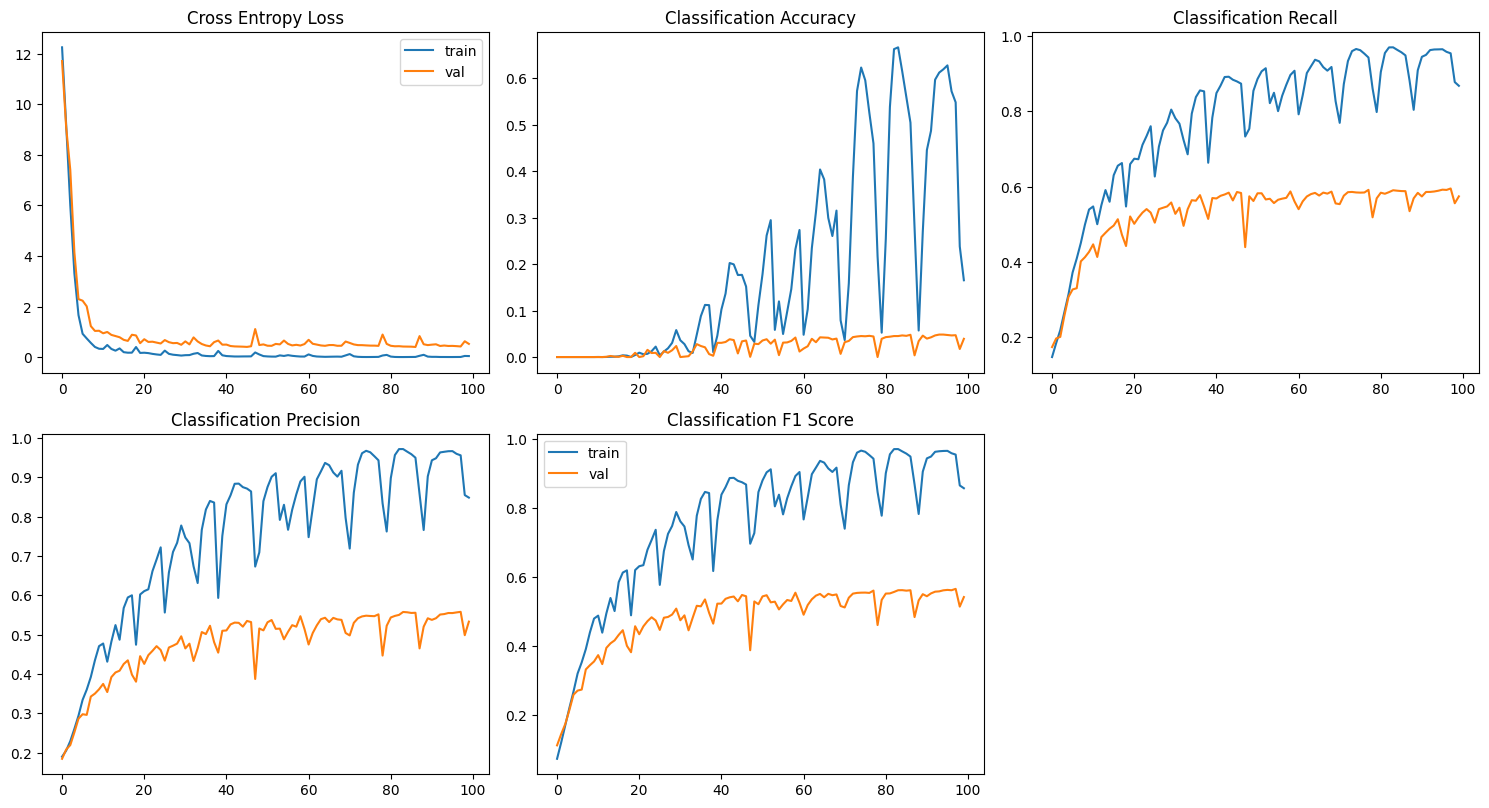

In [17]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [54]:
def plot_histogram(arr):
    max_histogram_missmatchs = 20
    arr_filtered = arr[:max_histogram_missmatchs]
    overMaxMissmachs = arr[max_histogram_missmatchs:]
    print("Filtered array:", arr_filtered)
    # Sum the values > max_histogram_missmatchs (if any exist)
    sum_over_16 = overMaxMissmachs.sum() if len(overMaxMissmachs) > 0 else 0

    # Create a new array for plotting (values ≤ 16 + one "16+" bin)
    new_arr = np.append(arr_filtered, sum_over_16)
    indices = np.arange(len(arr_filtered))
    indices = np.append(indices, str(max_histogram_missmatchs)+"+" )  # Add an index for the "16+" bin
    plt.figure(figsize=(8, 6))  # Wider graph (12 inches width, 6 height)
    # Plot the histogram (bar chart)
    plt.bar(indices, new_arr)

    # Add the numbers on top of each bar
    for i, value in enumerate(new_arr):
        if i == len(arr_filtered):
            plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom')
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of Array Values')
    plt.xticks(indices)  # Ensure all indices are shown

    # Display the plot
    plt.show()

100%|██████████| 142/142 [00:11<00:00, 12.86it/s]


Missing pieces per board: [105  56  56  70 140 176 199 244 200 225 156 137  98  87  56  43  32  19
  12   1   3   4   2   2   2   1   1   0   1   1   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Filtered array: [105  56  56  70 140 176 199 244 200 225 156 137  98  87  56  43  32  19
  12   1]


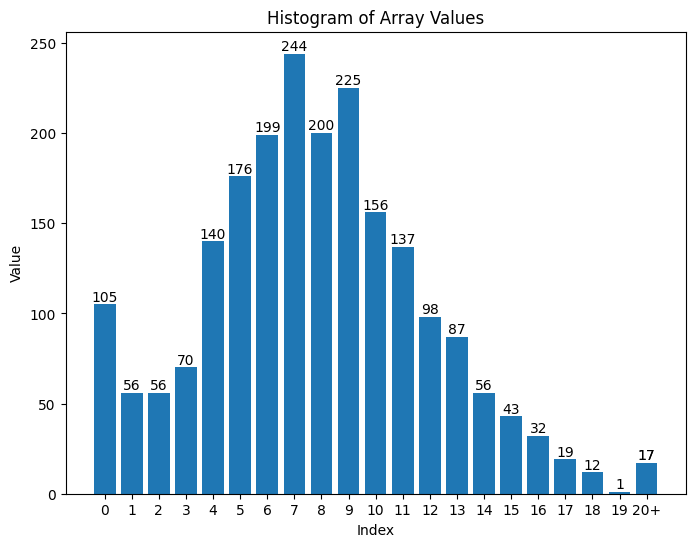

Test accuracy: 0.049, Test recall: 0.598, Test precision: 0.566, Test f1: 0.572


In [55]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])
def test(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.cpu()*12
            preds.append(predsTmp.cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds).round()
        all_labels = torch.cat(labels)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        missing_list = claculateMissMatchs(all_preds, all_labels)
        print("Missing pieces per board:", missing_list)
        plot_histogram(missing_list)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

  0%|          | 0/142 [00:00<?, ?it/s]

Predictions:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


Ground Truth:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Accuracy: 0.067, Recall: 0.919, Precision: 0.882, F1: 0.893


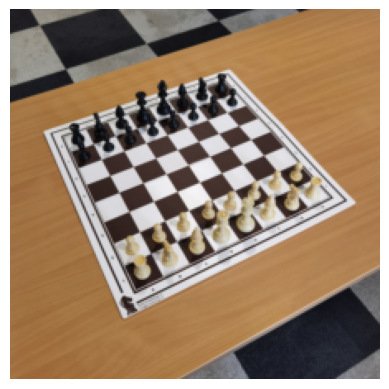

  1%|          | 1/142 [00:00<00:33,  4.26it/s]

Predictions:


['N', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'B', '-', 'P', '-']
['-', '-', 'N', 'P', '-', 'B', 'p', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', 'k', '-', '-']
['-', '-', 'n', 'r', 'n', 'n', '-', '-']
['p', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']


Ground Truth:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', 'b', 'p', '-', '-']
['p', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Accuracy: 0.000, Recall: 0.743, Precision: 0.695, F1: 0.704


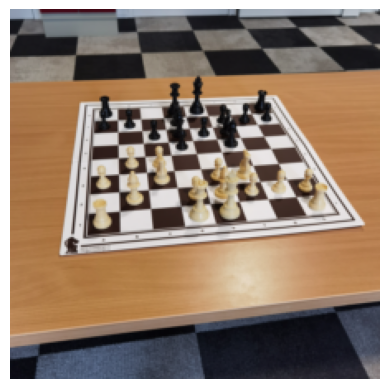

  1%|▏         | 2/142 [00:00<00:28,  4.96it/s]

Predictions:


['-', 'K', '-', 'R', '-', '-', '-', 'R']
['B', 'P', 'P', '-', 'B', '-', 'R', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', 'n', '-', '-', 'r', '-', 'r']
['-', 'p', 'p', 'n', 'n', '-', 'p', '-']
['-', 'k', '-', 'n', '-', '-', '-', 'r']


Ground Truth:


['-', 'K', '-', 'R', '-', '-', '-', 'R']
['b', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', 'n', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Accuracy: 0.000, Recall: 0.444, Precision: 0.409, F1: 0.409


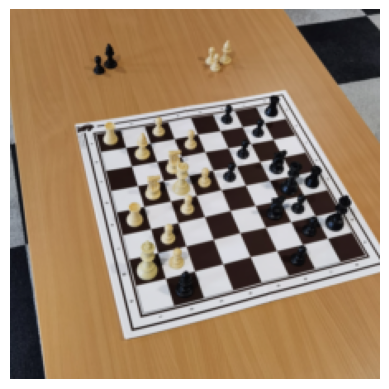

  2%|▏         | 3/142 [00:00<00:26,  5.31it/s]

Predictions:


['-', '-', '-', 'B', '-', '-', '-', 'B']
['-', 'N', 'k', '-', 'K', '-', 'p', '-']
['-', 'B', '-', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'n', 'R', 'r', '-']
['R', '-', '-', '-', '-', 'r', '-', 'p']
['-', 'K', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', 'n', '-']
['-', 'K', '-', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'p', 'P', 'p', '-']
['P', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Accuracy: 0.000, Recall: 0.348, Precision: 0.341, F1: 0.334


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


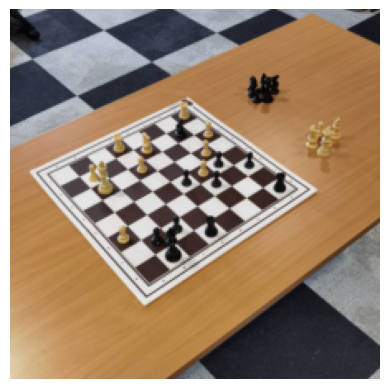

  3%|▎         | 4/142 [00:00<00:25,  5.51it/s]

Predictions:


['-', '-', '-', '-', '-', '-', '-', 'N']
['N', 'P', '-', 'K', '-', 'R', '-', '-']
['-', '-', '-', 'P', '-', '-', '-', '-']
['-', '-', '-', 'r', 'N', 'p', 'P', '-']
['-', '-', '-', '-', 'k', 'R', 'K', '-']
['p', 'r', '-', '-', '-', 'r', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


Ground Truth:


['-', '-', '-', '-', '-', '-', '-', 'R']
['K', 'P', '-', 'R', '-', 'N', '-', '-']
['-', '-', '-', 'P', '-', '-', '-', '-']
['-', '-', '-', 'r', 'p', 'n', 'P', '-']
['-', '-', '-', '-', '-', 'P', 'p', '-']
['p', 'r', '-', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Accuracy: 0.000, Recall: 0.380, Precision: 0.388, F1: 0.377


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


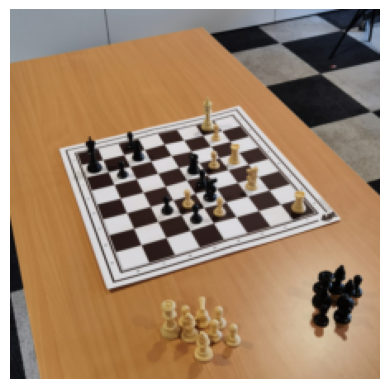

  4%|▎         | 5/142 [00:00<00:24,  5.63it/s]C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Predictions:


['-', 'K', '-', '-', '-', '-', '-', 'B']
['-', 'P', '-', '-', 'Q', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', 'n', '-', '-', '-', '-', 'p', '-']
['N', '-', '-', '-', '-', 'R', 'Q', '-']
['-', '-', 'n', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


Ground Truth:


['-', 'K', '-', '-', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'R', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', 'n', '-', '-', '-', '-', 'r', '-']
['N', '-', '-', '-', '-', 'P', 'p', '-']
['-', '-', 'r', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Accuracy: 0.000, Recall: 0.404, Precision: 0.428, F1: 0.413


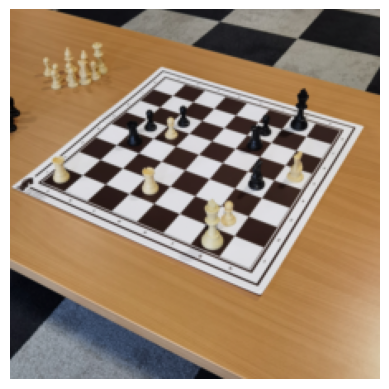

  4%|▎         | 5/142 [00:01<00:29,  4.57it/s]


In [24]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = (pred.cpu()*12).round().int()
            print("Predictions:\n\n")
            print_readable_board(predsTmp[0])
            print("\n\nGround Truth:\n\n")
            print_readable_board(y.cpu()[0])
            #print(pred.cpu().shape, y.cpu().shape)
            pred1 = (pred.cpu()*12).round().int()
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(pred1, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?